In [38]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz
from matplotlib import pyplot as plt
from matplotlib.pyplot import MultipleLocator
from sklearn import tree
from sklearn.model_selection import KFold
from mpl_toolkits.basemap import Basemap
from matplotlib.contour import QuadContourSet

In [3]:
forecastData = pd.read_csv("D:\datas\python\dachuang\\typhoon(CHINA)\台风预测值与真实值对照数据（12小时版）（原版） - 副本 - 副本.csv")

In [4]:
forecastData[forecastData['lon+0']>150]

,nums,time+0,lon+0,lat+0,power+0,speed+0,pressure+0,time+1,lon+1,lat+1,power+1,speed+1,pressure+1,forecastLon,forecastLat,forecastPressure,forecastSpeed
63,200910.0,2009/8/18 8:00,157.6,15.5,8.0,18.0,1000.0,2009/8/19 8:00,155.8,17.6,NaN,22.5,990.0,157.5,17.3,975.0,32.5
64,200910.0,2009/8/18 14:00,157.4,16.2,8.0,18.0,998.0,2009/8/19 14:00,155.7,18.9,NaN,22.5,990.0,157.7,17.7,975.0,32.5
65,200910.0,2009/8/18 20:00,157.1,16.7,8.0,20.0,995.0,2009/8/19 20:00,154.8,19.3,NaN,22.5,990.0,157.6,18.0,970.0,35.0
66,200910.0,2009/8/19 2:00,157.3,17.1,10.0,25.0,988.0,2009/8/20 2:00,154.7,19.5,NaN,27.5,985.0,157.5,18.2,960.0,40.0
67,200910.0,2009/8/19 8:00,157.5,17.3,12.0,33.0,975.0,2009/8/20 8:00,157.1,18.6,NaN,37.5,960.0,157.3,18.6,940.0,47.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11152,202301.0,2023/4/21 2:00,156.0,9.9,8.0,18.0,1000.0,2023/4/21 14:00,155.1,10.4,8.0,20.0,995.0,155.6,10.2,990.0,22.5
11153,202301.0,2023/4/21 5:00,155.8,10.0,8.0,20.0,995.0,2023/4/21 17:00,155.1,10.5,8.0,20.0,995.0,155.6,10.2,990.0,22.5
11154,202301.0,2023/4/21 8:00,155.6,10.1,8.0,20.0,995.0,2023/4/21 20:00,155.0,10.6,8.0,20.0,995.0,155.3,10.3,990.0,22.5
11155,202301.0,2023/4/21 14:00,155.6,10.2,9.0,23.0,992.0,2023/4/22 2:00,155.1,10.8,8.0,20.0,995.0,155.3,10.3,990.0,22.5


In [5]:
 #forecastData = forecastData.replace(['0', 'null', ' '], [np.nan, np.nan, np.nan])     这两段已近用过了
#forecastData.to_csv("D:\datas\python\dachuang\\typhoon(CHINA)\\typhoon forecast data2.csv", index=False)

In [6]:
forecastData = forecastData.dropna()
forecastData = forecastData.reset_index(drop=True)

In [7]:
forecastData

,nums,time+0,lon+0,lat+0,power+0,speed+0,pressure+0,time+1,lon+1,lat+1,power+1,speed+1,pressure+1,forecastLon,forecastLat,forecastPressure,forecastSpeed
0,200910.0,2009/8/22 2:00,156.7,22.1,16.0,53.0,935.0,2009/8/23 2:00,156.0,27.0,16.0,55.0,930.0,155.4,26.3,955.0,40.0
1,200910.0,2009/8/22 8:00,156.7,23.5,15.0,50.0,940.0,2009/8/23 8:00,155.7,28.7,14.0,45.0,950.0,155.0,27.5,955.0,40.0
2,200910.0,2009/8/22 14:00,156.3,24.6,14.0,45.0,950.0,2009/8/23 14:00,155.0,30.0,13.0,40.0,960.0,154.8,28.6,955.0,40.0
3,200910.0,2009/8/22 20:00,155.9,25.6,14.0,45.0,950.0,2009/8/23 20:00,155.2,30.4,13.0,40.0,960.0,154.6,29.3,955.0,40.0
4,200910.0,2009/8/23 2:00,155.4,26.3,13.0,40.0,955.0,2009/8/24 2:00,154.3,31.2,12.0,32.5,970.0,154.4,30.1,955.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10818,202306.0,2023/7/31 8:00,132.0,22.1,14.0,42.0,955.0,2023/7/31 20:00,130.7,23.7,14.0,40.0,955.0,131.1,23.4,935.0,50.0
10819,202306.0,2023/7/31 11:00,131.8,22.4,15.0,48.0,945.0,2023/7/31 23:00,130.5,23.8,15.0,50.0,940.0,130.8,23.7,935.0,50.0
10820,202306.0,2023/7/31 14:00,131.5,22.8,15.0,50.0,940.0,2023/8/1 2:00,130.0,24.0,15.0,50.0,940.0,130.3,24.0,935.0,50.0
10821,202306.0,2023/7/31 17:00,131.4,23.1,16.0,52.0,935.0,2023/8/1 5:00,129.8,24.2,16.0,55.0,930.0,129.8,24.5,935.0,50.0


In [8]:
forecastDataOrigin = forecastData[['lon+0', 'lat+0', 'speed+0', 'pressure+0']]
realLat = pd.DataFrame(forecastData.loc[:, 'forecastLat'] - forecastData.loc[:, 'lat+1'], columns=['lat'])
realLon = pd.DataFrame(forecastData.loc[:, 'forecastLon'] - forecastData.loc[:, 'lon+1'], columns=['lon'])
realPressure = pd.DataFrame(forecastData.loc[:, 'forecastPressure'] - forecastData.loc[:, 'pressure+1'], columns=['pressure'])
realSpeed = pd.DataFrame(forecastData.loc[:, 'forecastSpeed'] - forecastData.loc[:, 'speed+1'], columns=['speed'])
realRoute = pd.concat([realLat, realLon], axis=1, keys=['lat', 'lon'])

In [9]:
speedVar = float(np.var(realSpeed))
speedMean = float(realSpeed.mean(axis=0))
latVar = float(np.var(realLat))
latMean = float(realLat.mean(axis=0))
lonVar = float(np.var(realLon))
lonMean = float(realLon.mean(axis=0))
pressureVar = float(np.var(realPressure))
pressureMean = float(realPressure.mean(axis=0))
realSpeed.loc[(realSpeed['speed']>-5)&(realSpeed['speed']<5), 'error'] = 'less than 1sigma'
realSpeed.loc[(realSpeed['speed']<=-5)|(realSpeed['speed']>=5), 'error'] = 'more than 1sigma'
realPressure.loc[(realPressure['pressure']>-5)&(realPressure['pressure']<5), 'error'] = 'less than 1sigma'
realPressure.loc[(realPressure['pressure']<=-5)|(realPressure['pressure']>=5), 'error'] = 'more than 1sigma'
realLat.loc[(realLat['lat']>latMean-latVar)&(realLat['lat']<latMean+latVar), 'error'] = 'less than 1sigma'
realLat.loc[(realLat['lat']<=latMean-latVar)|(realLat['lat']>=latMean+latVar), 'error'] = 'more than 1sigma'
realLon.loc[(realLon['lon']>lonMean-lonVar)&(realLon['lon']<lonMean+lonVar), 'error'] = 'less than 1sigma'
realLon.loc[(realLon['lon']<=lonMean-lonVar)|(realLon['lon']>=lonMean+lonVar), 'error'] = 'more than 1sigma'
realRoute = pd.concat([realLat, realLon], axis=1, keys=['lat', 'lon'])

In [10]:
originTrain1, originTest1, routeTrain, routeTest = train_test_split(forecastDataOrigin , realLat['error'], random_state=17)
originTrain2, originTest2, pressureTrain, pressureTest = train_test_split(forecastDataOrigin, realPressure['error'], random_state=17)
originTrain3, originTest3, speedTrain, speedTest = train_test_split(forecastDataOrigin, realSpeed['error'], random_state=17)

In [11]:
def creatEst(x, y):
    kf = KFold(n_splits=5)
    estList = []
    for train, test in kf.split(originTrain1):
        xTrain, xTest, yTrain, yTest = train_test_split(originTrain1.iloc[train], realLat['error'].iloc[train], random_state=17)
        estimator = DecisionTreeClassifier(max_depth=4, min_samples_leaf=5, min_samples_split=4)
        estimator.fit(xTrain, yTrain)
        estList.append(estimator)
    return estList

In [12]:
routeList = creatEst(originTrain1, routeTrain)
pressureList = creatEst(originTrain2, pressureTrain)
speedList = creatEst(originTrain3, speedTrain)

In [13]:
np.set_printoptions(threshold=np.inf)
#routeList[1].predict(originTest1)
routeTest.count()

2706

In [14]:
(routeList[1].predict(originTest1) == routeTest).value_counts()

True     1901
False     805
Name: error, dtype: int64

In [15]:
(pressureList[4].predict(originTest2) == pressureTest).value_counts()

True     1488
False    1218
Name: error, dtype: int64

In [16]:
(speedList[1].predict(originTest3) == speedTest).value_counts()

False    2116
True      590
Name: error, dtype: int64

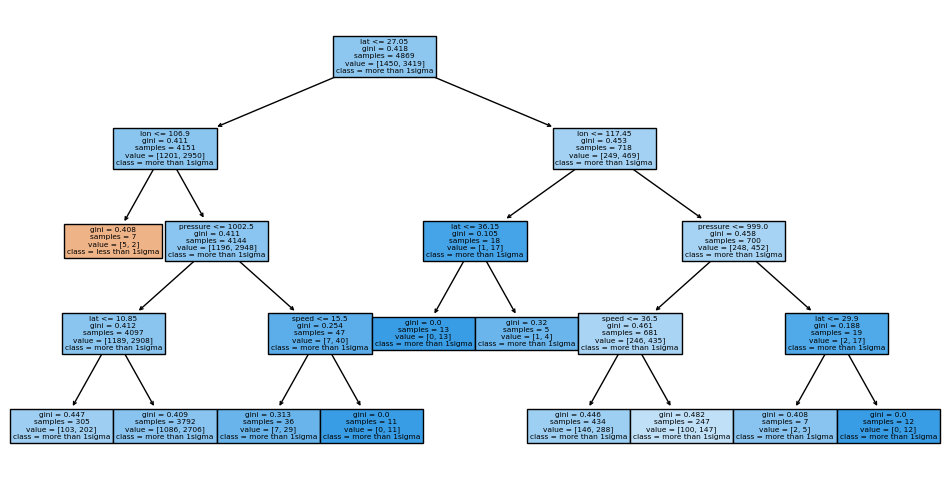

In [17]:
fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(
    routeList[1], 
    feature_names=['lon', 'lat','speed', 'pressure'],  
    class_names=['less than 1sigma', 'more than 1sigma'],
    filled=True
)
fig.savefig(".\分类结果（lat）.png", dpi=800)

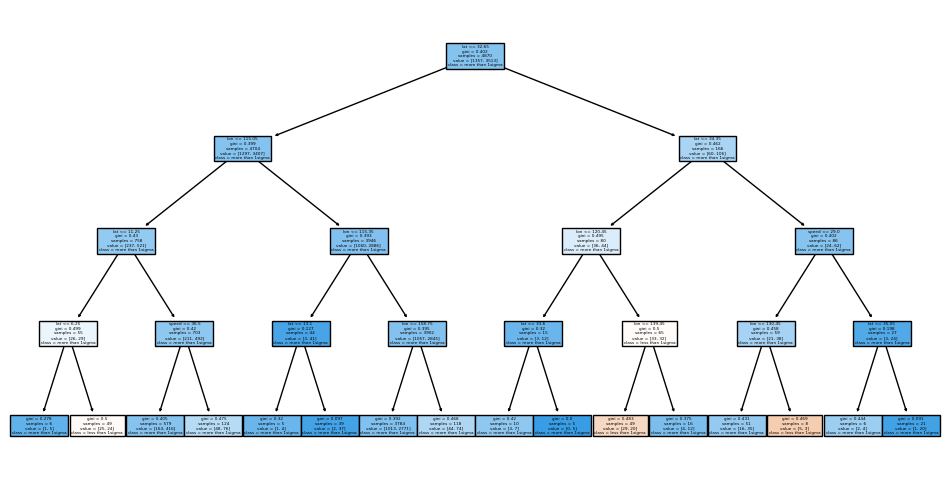

In [18]:
fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(
    pressureList[4], 
    feature_names=['lon', 'lat','speed', 'pressure'],  
    class_names=['less than 1sigma', 'more than 1sigma'],
    filled=True
)
fig.savefig(".\分类结果（气压）.png", dpi=800)

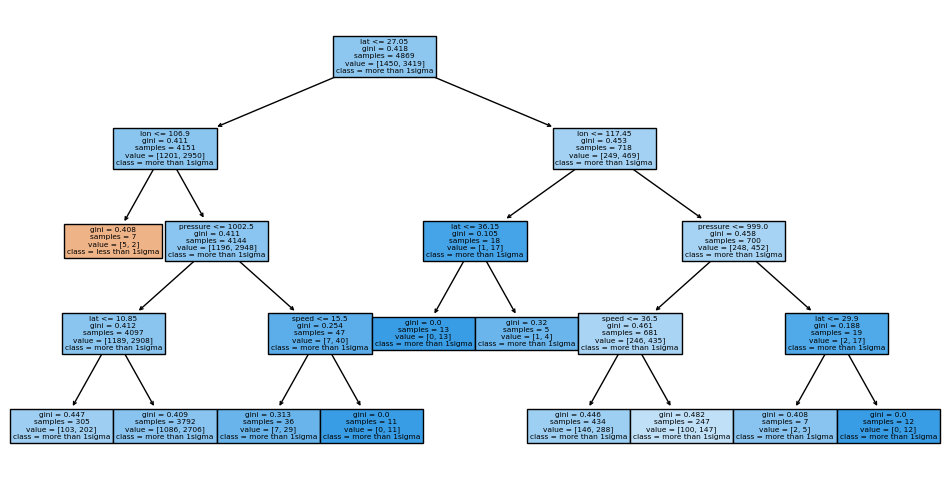

In [19]:
fig = plt.figure(figsize=(12,6))
_ = tree.plot_tree(
    speedList[1], 
    feature_names=['lon', 'lat','speed', 'pressure'],  
    class_names=['less than 1sigma', 'more than 1sigma'],
    filled=True
)
fig.savefig(".\分类结果（速度）.png", dpi=800)

In [20]:
#pd.set_option('display.max_rows', None)
realRoute[(realRoute['lat']['error']=='more than 1sigma')&(realRoute['lon']['error']=='more than 1sigma')]

lat                    lon                  
       lat             error  lon             error
0     -0.7  more than 1sigma -0.6  more than 1sigma
1     -1.2  more than 1sigma -0.7  more than 1sigma
2     -1.4  more than 1sigma -0.2  more than 1sigma
3     -1.1  more than 1sigma -0.6  more than 1sigma
5     -1.4  more than 1sigma -0.2  more than 1sigma
...    ...               ...  ...               ...
10808 -0.2  more than 1sigma  0.3  more than 1sigma
10809 -0.5  more than 1sigma -0.2  more than 1sigma
10815 -0.5  more than 1sigma  0.3  more than 1sigma
10818 -0.3  more than 1sigma  0.4  more than 1sigma
10822  0.5  more than 1sigma -0.4  more than 1sigma

[4369 rows x 4 columns]

In [1]:
errPressure = forecastDataOrigin.iloc[realPressure[realPressure['error']=='more than 1sigma'].index]
plt.subplot2grid((2, 3), (0, 0))
plt.hist(errPressure['pressure+0'])
plt.title('pressure')
plt.subplot2grid((2, 3), (1, 0))
plt.hist(errPressure['speed+0'])
plt.title('speed')
plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
m = Basemap(projection='cyl',llcrnrlon=90.,llcrnrlat=0.,urcrnrlon=180.,urcrnrlat=45.,resolution="i")
m.drawcoastlines()
m.drawmapboundary(fill_color='#87CEEB')
m.fillcontinents(color='#FFFFFF',lake_color='#87CEEB')
co = plt.hist2d(errPressure['lon+0'], errPressure['lat+0'], bins=(30, 30), range=[[90, 180], [0, 40]])
coCompare = plt.hist2d(forecastData['lon+0'], forecastData['lat+0'], bins=(30, 30), range=[[90, 180], [0, 40]])
co = np.divide(co[0], coCompare[0]+1)
plt.contourf(coCompare[1], coCompare[2], co, cmap="Blues", vmin=0.6)
plt.colorbar(label='percentage')
plt.title('coordinate' + '\ntotal: ' + str(errPressure['pressure+0'].shape[0]))
plt.suptitle('error of pressure')
plt.tight_layout()
#plt.savefig(".\气压误差直方图.png", dpi=600)
plt.show()
plt.close()

NameError: name 'forecastDataOrigin' is not defined

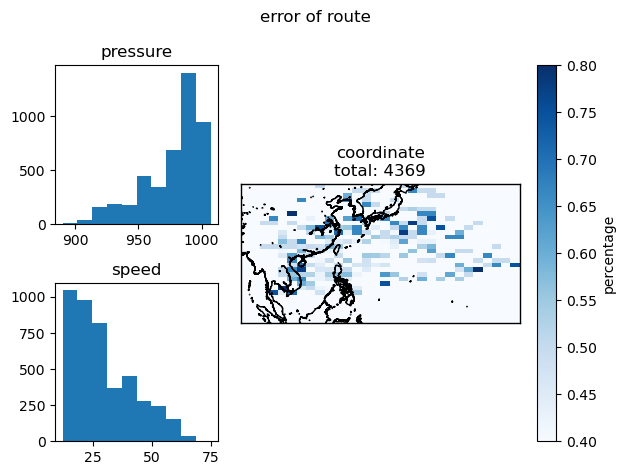

In [28]:
errRoute = forecastDataOrigin.iloc[realRoute[(realRoute['lat']['error']=='more than 1sigma')&(realRoute['lon']['error']=='more than 1sigma')].index]
plt.subplot2grid((2, 3), (0, 0))
plt.hist(errRoute['pressure+0'])
plt.title('pressure')
plt.subplot2grid((2, 3), (1, 0))
plt.hist(errRoute['speed+0'])
plt.title('speed')
plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
m = Basemap(projection='cyl',llcrnrlon=90.,llcrnrlat=0.,urcrnrlon=180.,urcrnrlat=45.,resolution="i")
m.drawcoastlines()
m.drawmapboundary(fill_color='#87CEEB')
m.fillcontinents(color='#FFFFFF',lake_color='#87CEEB')
co = plt.hist2d(errRoute['lon+0'], errRoute['lat+0'], bins=(30, 30), range=[[90, 180], [0, 45]])
coCompare = plt.hist2d(forecastData['lon+0'], forecastData['lat+0'], bins=(30, 30), range=[[90, 180], [0, 45]])
co = np.divide(co[0], coCompare[0]+1)
plt.pcolormesh(coCompare[1], coCompare[2], co, cmap="Blues", vmin=0.4)
plt.colorbar(label='percentage')
plt.title('coordinate' + '\ntotal: ' + str(errRoute['lon+0'].shape[0]))
plt.suptitle('error of route')
plt.tight_layout()
#plt.savefig(".\路径误差直方图.png", dpi=600)
plt.show()
plt.close()

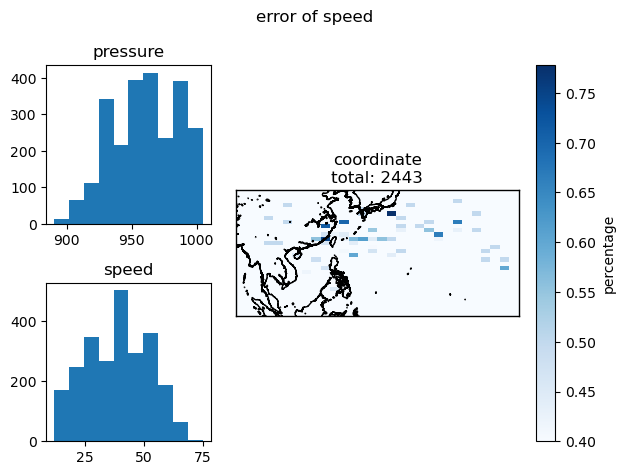

In [29]:
errSpeed = forecastDataOrigin.iloc[realSpeed[realSpeed['error']=='more than 1sigma'].index]
plt.title('速度误差直方图')
plt.subplot2grid((2, 3), (0, 0))
plt.hist(errSpeed['pressure+0'])
plt.title('pressure')
plt.subplot2grid((2, 3), (1, 0))
plt.hist(errSpeed['speed+0'])
plt.title('speed')
plt.subplot2grid((2, 3), (0, 1), colspan=2, rowspan=2)
m = Basemap(projection='cyl',llcrnrlon=90.,llcrnrlat=0.,urcrnrlon=180.,urcrnrlat=45.,resolution="i")
m.drawcoastlines()
m.drawmapboundary(fill_color='#87CEEB')
m.fillcontinents(color='#FFFFFF',lake_color='#87CEEB')
coSpeed = plt.hist2d(errSpeed['lon+0'], errSpeed['lat+0'], bins=(30, 30), range=[[90, 180], [0, 40]])
coCompare = plt.hist2d(forecastData['lon+0'], forecastData['lat+0'], bins=(30, 30), range=[[90, 180], [0, 40]])
coSpeed = np.divide(coSpeed[0], coCompare[0]+1)
plt.pcolormesh(coCompare[1], coCompare[2], coSpeed, cmap="Blues", vmin=0.4)
plt.colorbar(label='percentage')
plt.title('coordinate' + '\ntotal: ' + str(errSpeed['pressure+0'].shape[0]))
plt.suptitle('error of speed')
plt.tight_layout()
#plt.savefig(".\速度误差直方图.png", dpi=600)
plt.show()
plt.close()